In [1]:
from solartwins import *
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
from pandas import DataFrame
import matplotlib.pyplot as plt
import astropy.stats as astat
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
table= t.copy()

table.remove_column('O')
table.remove_column('C')

elements =[]
elnames = table.columns[3:64]
for n in elnames:
    if len(n) < 3 :
        elements.append(n)

atomic_number = [26, 11, 12, 13, 14, 16, 20, 23, 25, 27, 28, 29, 30, 38, 
                39, 40, 56, 57, 58, 59, 60, 62, 63, 64, 66, 22, 21, 24]

element_names = ['Iron', 'Sodium', 'Magnesium', 'Aluminum', 'Silicon', 'Sulfur', 'Calcium', 'Vanadium', 'Manganese', 
    'Cobalt', 'Nickel', 'Copper', 'Zinc', 'Strontium', 'Yttrium', 'Zirconium', 'Barium', 'Lanthanum ', 'Cesium', 
    'Praseodymium', 'Neodymium', 'Samarium', 'Europium', 'Gadolinium', 'Dysprosium', 'Titanium', 'Scandium']

In [3]:
#slopes before condesation trends removed
slopes_before = []
for each, element in enumerate(elements):
    x0 = (0.00984496, -0.03665832, -0.01235449) #one-dimensional optimization
    restemp = scipy.optimize.minimize(nlnL, x0, args = (t['age'],t[element],t[element + '_err']))
    #star age vs abundance slope before removing temp trends
    mbtemp= restemp['x']
    slopes_before.append(mbtemp[0])
    
    restemp = 0 #making sure it resets

In [4]:
#slopes after Tc trend removed - correct condensation temps
slopes_after = []
for each, element in enumerate(elements):
    el_con_temp = []
    for ob in t['star_name']:
        abund = np.array(star_table(ob)['Abundance'])
        con_temp = np.array(star_table(ob)['Condensation Temp'])
        error = np.array(star_table(ob)['Abundance Error'])
        residu = residuals(con_temp, abund, error)
        el_con_temp.append(residu[each])

    x1 = (0.00135163, -0.00619703, -0.00397238) #one-dimensional optimization
    reso = scipy.optimize.minimize(nlnL, x1, args = (t['age'], el_con_temp, t[element + '_err']))
    mb= reso['x']
    slopes_after.append(mb[0])
    
    reso = 0

In [5]:
con_temp_shuffle = []
for n in elements:
    con_temp_shuffle.append(tc_map[n]) 

In [6]:
slopes = []
con_temp_shuffle = []
for n in elements:
    con_temp_shuffle.append(tc_map[n])  
    
for each, element in enumerate(elements):
    el_slopes = []
    for i in tqdm(range(1000)):
        np.random.shuffle(con_temp_shuffle) #random condensation temperatures
        el_con_temp = []
        for ob in t['star_name']:
            abund = np.array(star_table(ob)['Abundance'])
            con_temp = np.array(con_temp_shuffle)
            error = np.array(star_table(ob)['Abundance Error'])
            residu = residuals(con_temp, abund, error)
            el_con_temp.append(residu[each])

        x1 = (0.00135163, -0.00619703, -0.00397238) #one-dimensional optimization
        reso = scipy.optimize.minimize(nlnL, x1, args = (t['age'], el_con_temp, t[element + '_err']))
        mb= reso['x']
        el_slopes.append(mb[0])
    slopes.append(el_slopes)

100%|██████████| 1000/1000 [14:41<00:00,  1.13it/s]


In [7]:
#violin plot of slope values from trials

In [20]:
slope_after = []
for each, element in enumerate(elements):
    el_con_temp = []   
    for ob in t['star_name']:
        abund = np.array(star_table(ob)['Abundance'])
        con_temp = np.array(star_table(ob)['Condensation Temp'])
        error = np.array(star_table(ob)['Abundance Error'])
        residu = residuals(con_temp, abund, error)
        el_con_temp.append(residu[each])

    x1 = (0.00135163, -0.00619703, -0.00397238) #one-dimensional optimization
    reso = scipy.optimize.minimize(nlnL, x1, args = (t['age'], el_con_temp, t[element + '_err']))
    mbtemp= reso['x']
    slope_after.append(mbtemp[0])
    el_con_temp = []
    reso = 0
    x1=(0,0,0)
    
slope_after= np.array(slope_after)

In [23]:
dev_differences_sorted = {} 
for val, e in tqdm(enumerate(elements)): 
    dev_differences_sorted['difference' + e] = []
    for index, each in enumerate(slopes[:,val]):
        diff_sort = (slopes[index, val]) - slope_after[val]
        dev_differences_sorted['difference'+ e].append(diff_sort)

0it [00:00, ?it/s]


TypeError: list indices must be integers or slices, not tuple

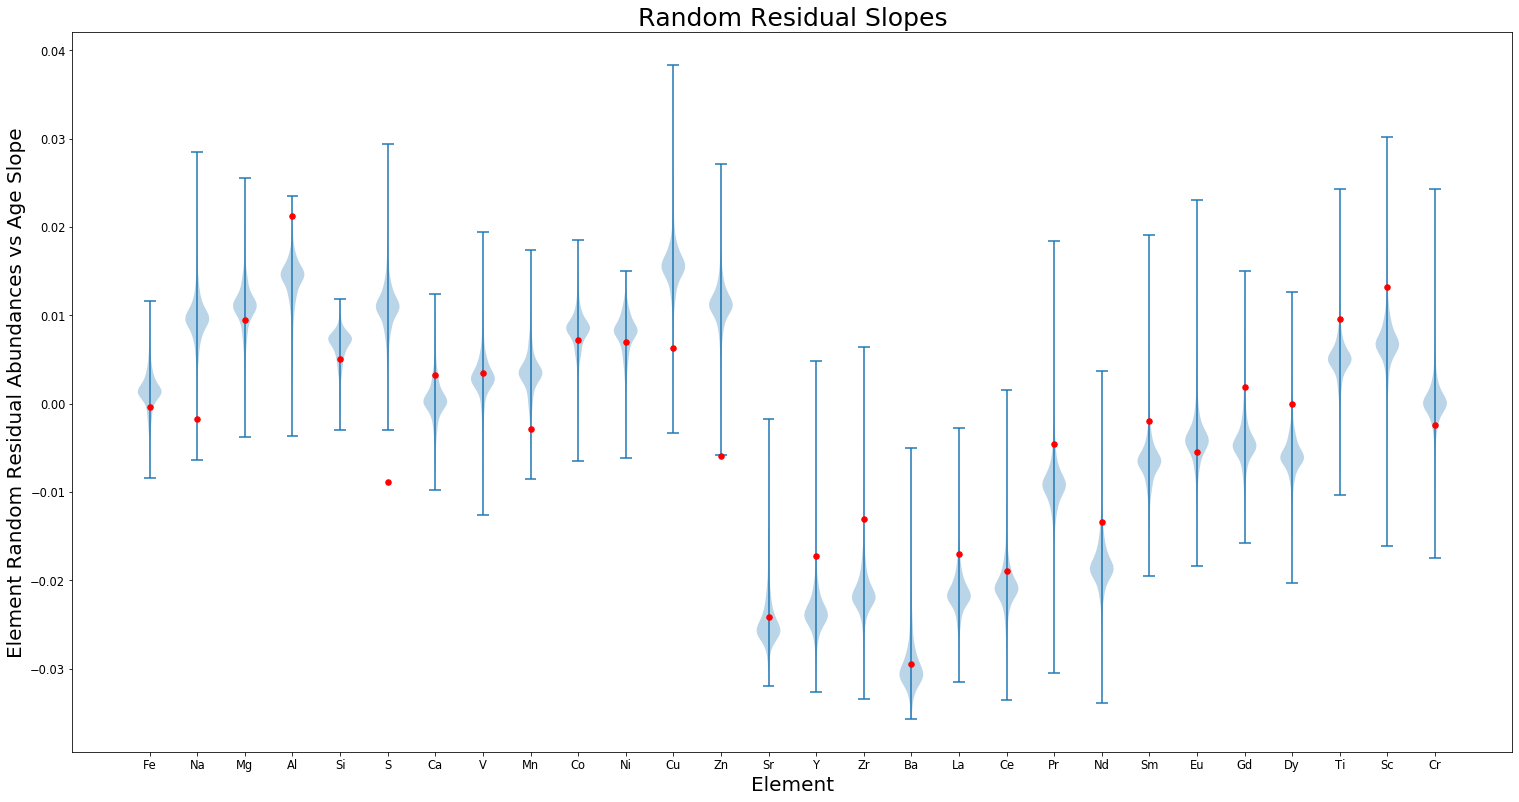

<Figure size 1440x720 with 0 Axes>

In [21]:
position_sort = np.array(elements)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

#data_to_plot_sort =[]
#for each, val in enumerate(elements):
    #dif_sort = np.asarray(dev_differences_sorted['difference'+ val])
    #data_to_plot_sort.append(dif_sort)
    #dif_sort = []

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bps = ax.violinplot(slopes)
    
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28],position_sort, fontsize = 11.5)
plt.yticks(fontsize=11.5)
plt.title('Random Residual Slopes', fontsize=25)
inds = np.arange(1, len(slope_after) + 1)
plt.scatter(inds, slope_after, marker='o', color='r', s=30, zorder=27)

plt.xlabel('Element', fontsize = 20)
plt.ylabel('Element Random Residual Abundances vs Age Slope', fontsize = 20)


#for i, txt in enumerate(elements): 
    #plt.annotate(txt, xy=(elements[i], .055), xytext = (-5,5), fontsize=20, 
                 #textcoords='offset points', ha='center', va='bottom')

plt.show()
plt.savefig('slopevio.png')

In [26]:
File = open('list.txt', 'w')
for i in slopes:
    File.write(str(i) + "\n")
 
File.close()